# XGboosting

## Imports


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [11]:
import xgboost as xgb
from util import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix ,f1_score


NUM_FOLDS = 10


## Reading the data


In [4]:
X, y = get_train_data(path='../data/train.csv')

In [5]:
# standardize the data
X = standardize_features(X)

In [6]:
X.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Training the model


### Parameters for Tree Booster

- **eta** *[default=0.3, alias: learning_rate]*:
  - Step size shrinkage used in updates to prevent overfitting. It shrinks the feature weights after each boosting step to make the process more conservative.
  - Range: [0,1]

- **gamma** *[default=0, alias: min_split_loss]*:
  - Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values make the algorithm more conservative.
  - Range: [0,∞]

- **max_depth** *[default=6]*:
  - Maximum depth of a tree. Increasing it makes the model more complex and more likely to overfit. 0 indicates no limit on depth.
  - Range: [0,∞]

- **min_child_weight** *[default=1]*:
  - Minimum sum of instance weight needed in a child node. If partitioning a leaf results in a child with a sum of instance weight less than this, further partitioning is halted.
  - Range: [0,∞]

- **max_delta_step** *[default=0]*:
  - Maximum delta step allowed for each leaf output. Values >0 make the update step more conservative.
  - Range: [0,∞]

- **subsample** *[default=1]*:
  - Subsample ratio of the training instances. Setting it to 0.5 means randomly sampling half of the training data prior to growing trees.
  - Range: (0,1]

- **sampling_method** *[default=uniform]*:
  - The method to sample training instances. 
  - Choices: uniform (equal probability for each instance), gradient_based (probability proportional to the absolute value of gradients).

- **colsample_bytree, colsample_bylevel, colsample_bynode** *[default=1]*:
  - Subsampling of columns.
  - Range: (0, 1]
  - `colsample_bytree`: Subsample ratio of columns when constructing each tree.
  - `colsample_bylevel`: Subsample ratio of columns for each level.
  - `colsample_bynode`: Subsample ratio of columns for each node (split).

- **lambda** *[default=1, alias: reg_lambda]*:
  - L2 regularization term on weights. Increasing it makes the model more conservative.
  - Range: [0,∞]

- **alpha** *[default=0, alias: reg_alpha]*:
  - L1 regularization term on weights. Increasing it makes the model more conservative.
  - Range: [0,∞]

- **tree_method** *[default=auto]*:
  - The tree construction algorithm used in XGBoost.
  - Choices: auto, exact, approx, hist.

- **scale_pos_weight** *[default=1]*:
  - Control the balance of positive and negative weights, useful for unbalanced classes.

In [8]:
params = {
    "device": "cuda",
    # "tree_method": "gpu_hist"
    "tree_method": "hist"
}
xgb_model = xgb.XGBClassifier(**params)
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = xgb_model.predict(X_train)

# Compute training error
training_error = np.mean(y_train != y_train_pred)
print("Training error:", training_error)
print("Training accuracy:", 1 - training_error)

Training error: 0.0
Training accuracy: 1.0


c:\Users\bemoi\miniconda3\envs\v38_env\lib\site-packages\xgboost\core.py:160: UserWarning: [20:03:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


`cross_validate` function in scikit-learn is used for evaluating estimator performance using cross-validation. It takes several parameters to customize its behavior. Here are the main parameters:

1. **estimator**: This is the machine learning estimator (model) that you want to evaluate.

2. **X**: The feature matrix (data) to fit the model on.

3. **y**: The target values (labels) corresponding to X.

4. **cv**: The cross-validation strategy. It could be an integer specifying the number of folds in a KFold, a cross-validation splitter, or an iterable yielding train/test splits.

5. **scoring**: A single string or a callable to evaluate the predictions on the test set. For example, `'accuracy'`, `'precision'`, `'recall'`, `'f1'`, etc.

6. **n_jobs**: The number of CPU cores to use for computation. `-1` means using all processors.

7. **return_train_score**: Whether to include training scores in the output. Default is `False`.

8. **return_estimator**: Whether to return the fitted estimators for each split. Default is `False`.

9. **verbose**: Controls the verbosity: the higher, the more messages.

10. **fit_params**: Parameters to pass to the `fit` method of the estimator.

11. **pre_dispatch**: Controls the number of jobs dispatched during parallel execution. `-1` means all processes are dispatched at once, `2` means that two processes are dispatched, and `None` means that as many processes as CPUs are used.

These are the main parameters, but there are a few more which you can find in the scikit-learn documentation for the `cross_validate` function.

In [9]:
cv_results = cross_validate(xgb_model, X_train, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

accuracy:  0.9006250000000001
f1_macro:  0.48526102277051564
f1_micro:  0.9006250000000001


In [13]:
xgb_predictions = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_predictions)
print("XGB Accuracy:", xgb_accuracy)

print("Classification Report:")
print(classification_report(y_val, xgb_predictions))

XGB Accuracy: 0.915
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       366
           1       0.50      0.03      0.06        34

    accuracy                           0.92       400
   macro avg       0.71      0.51      0.51       400
weighted avg       0.88      0.92      0.88       400



## Model Analysis


### Feature Importance Plot

A feature importance plot shows the importance of each feature in the model. It can be used to identify the most important features and to understand the impact of each feature on the model's predictions.


     feature  importance
136  var_139        19.0
88    var_91        17.0
104  var_107        16.0
106  var_109        16.0
166  var_169        15.0
..       ...         ...
22    var_23         1.0
19    var_20         1.0
115  var_118         1.0
167  var_170         1.0
169  var_172         1.0

[197 rows x 2 columns]


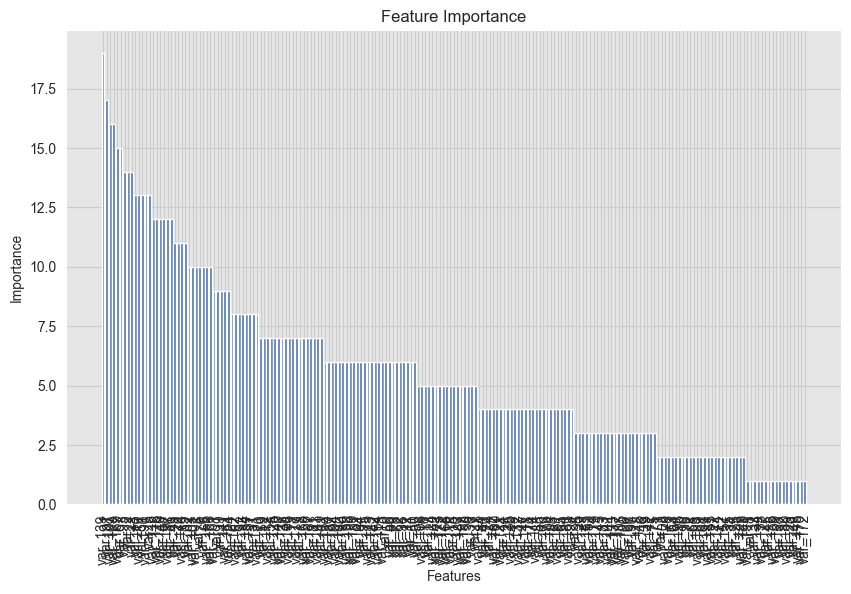

In [14]:
# Assuming you have trained your XGBoost classifier and stored it in xgb_model
importance = xgb_model.get_booster().get_score(importance_type='weight')
features = list(importance.keys())
importance_values = list(importance.values())

# Get feature importance using the provided function
feature_importance = get_feature_importance(features, importance_values)

# Print or return the sorted DataFrame
print(feature_importance)

plt = get_feature_importance_plot(
    feature_importance, modelname='XGB')
plt.show()


### Learning Curves Plot

show the training error (Ein) and validation error (Eval) as a function of the training set size


In [18]:
X_train_temp = X_train.copy()

In [19]:
imp_threshold = 5
for i in range(len(feature_importance)):
    if feature_importance['importance'][i] < imp_threshold:
        # remove the feature from the training data that has importance < imp_threshold
        X_train_temp = X_train_temp.drop(
            columns=feature_importance['feature'][i])
len(X_train_temp.columns)

108

In [20]:

cv_results = cross_validate(xgb_model, X_train_temp, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


accuracy:  0.9018750000000001
f1_macro:  0.4966858320342931
f1_micro:  0.9018750000000001
accuracy:  0.9018750000000001
f1_macro:  0.4966858320342931
f1_micro:  0.9018750000000001


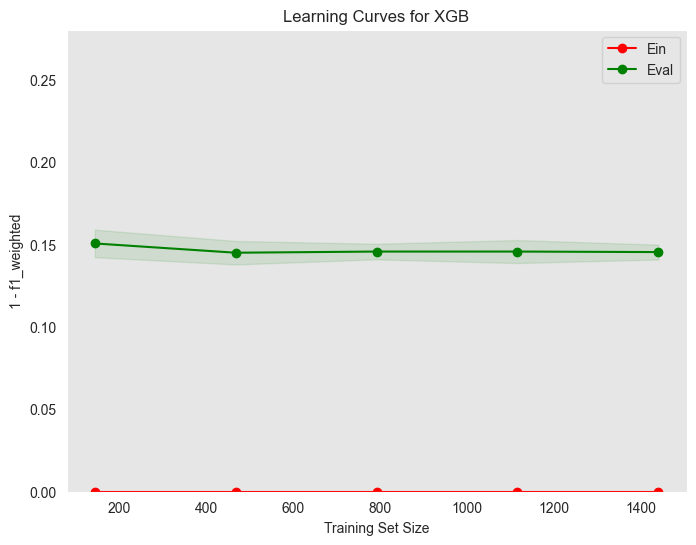

In [21]:
plt = get_learning_curve_plot(estimator=xgb.XGBClassifier(**params), X=X_train, y=y_train, cv=NUM_FOLDS, modelname='XGB')
plt.show()


### Partial Dependence Plot

A partial dependence plot shows the relationship between a feature and the model's predictions while holding all other features constant. It can be used to understand the impact of a single feature on the model's predictions i.e. PDPs show the average effect on predictions as the value of feature changes.

From the plots, we may see the type of the relationship between a feature and a prediction. Some relationships may look linear whereas other are more complex.


In [22]:
plt = get_partial_dependencies_plot(xgb_model, X_train, modelname='XGB', save=True)
plt.show()


c:\Users\bemoi\miniconda3\envs\v38_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\bemoi\miniconda3\envs\v38_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\bemoi\miniconda3\envs\v38_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
c:\Users\bemoi\miniconda3\envs\v38_env\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding

ValueError: Image size of 4500x120600 pixels is too large. It must be less than 2^16 in each direction.

### Hyperparameter Tuning

This is a process of adjusting the parameters of a model to optimize its performance. It can be done using techniques like grid search, random search, or Bayesian optimization.


In [24]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2, 0.3],
}


### Grid Search


In [26]:
# read the test data
X_test,y_test = get_test_data()

Best parameters found: {'gamma': 0, 'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}
Best score found: 0.8695480513489848
Test score with best parameters: 0.7275042996845676


ValueError: Must pass 2-d input. shape=(4, 3, 4)

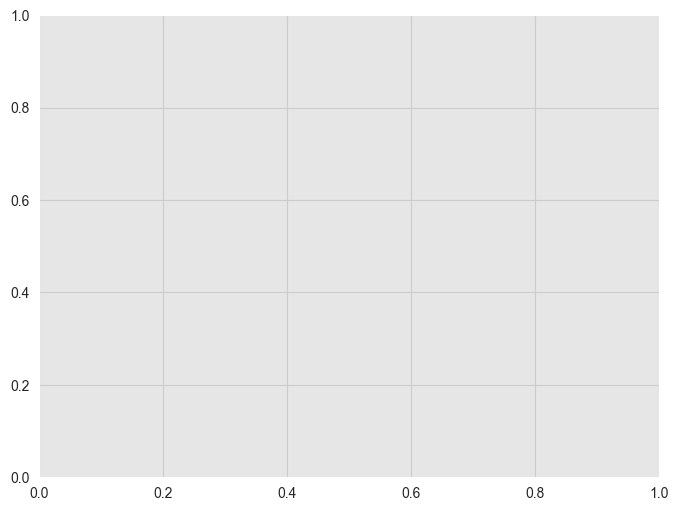

In [27]:
model_name = 'XGB'
grid_search = get_grid_search(estimator=xgb.XGBClassifier(**params), param_grid=param_grid, X=X, y=y, cv=NUM_FOLDS, scoring='f1_weighted')
# Print the results
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print("Test score with best parameters:", grid_search.score(X_test, y_test))
# Get the results
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Prepare the hyperparameter values for plotting
param_values_lr = param_grid['learning_rate']
param_values_md = param_grid['max_depth']
param_values_ne = param_grid['n_estimators']
param_values_gm = param_grid['gamma']

# Reshape the mean test scores for plotting
mean_test_scores = np.array(mean_test_scores).reshape(len(param_values_lr), len(param_values_md), len(param_values_ne),len(param_values_gm))

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of mean test scores
sns.heatmap(mean_test_scores.mean(axis=0), annot=True, cmap='viridis', xticklabels=param_values_lr, yticklabels=param_values_md)

# Set labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('Mean Test Scores')

# Show the plot
plt.show()
# save the plot
plt.savefig(f'../images/{model_name}/mean_test_scores_1.png', dpi=300, bbox_inches='tight')
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of mean test scores
sns.heatmap(mean_test_scores.mean(axis=1), annot=True, cmap='viridis', xticklabels=param_values_ne, yticklabels=param_values_gm)

# Set labels and title
plt.xlabel('N estimators')
plt.ylabel('Gamma')
plt.title('Mean Test Scores')

# Show the plot
plt.show()
# save the plot
plt.savefig(f'../images/{model_name}/mean_test_scores_2.png', dpi=300, bbox_inches='tight')

### Heatmap


IndexError: index 4 is out of bounds for axis 0 with size 4

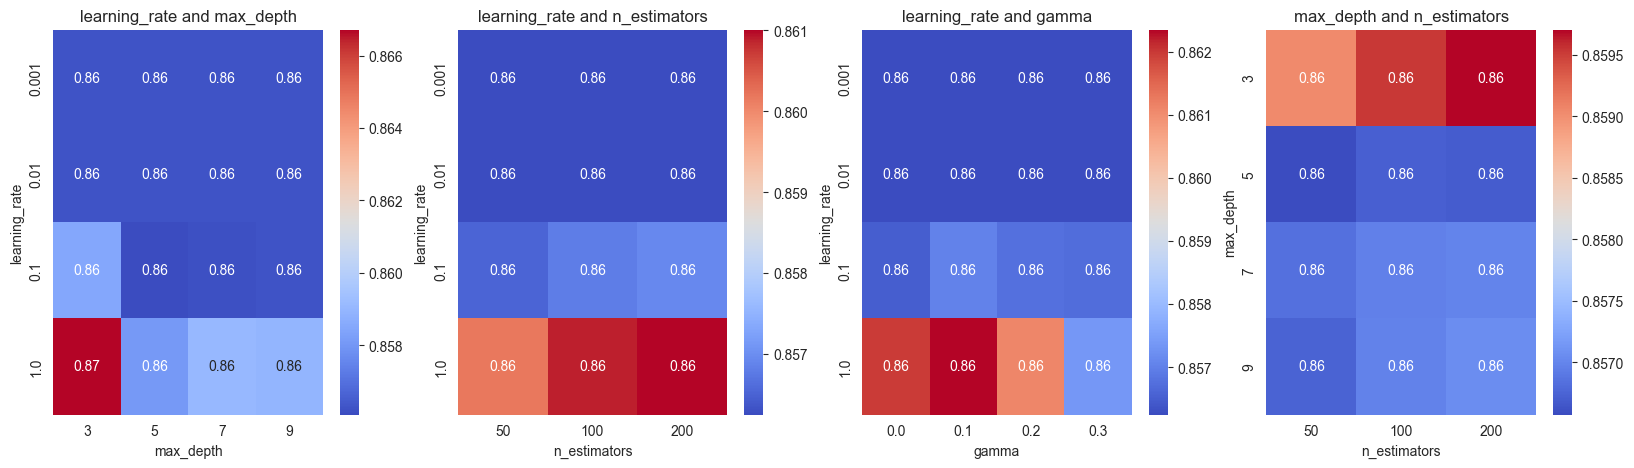

In [28]:
plot_hyper_param_heat_maps(param_grid, grid_search,modelname='XGB')


### Train-Validation Curve


Value [0.001, 0.01, 0.1, 1]


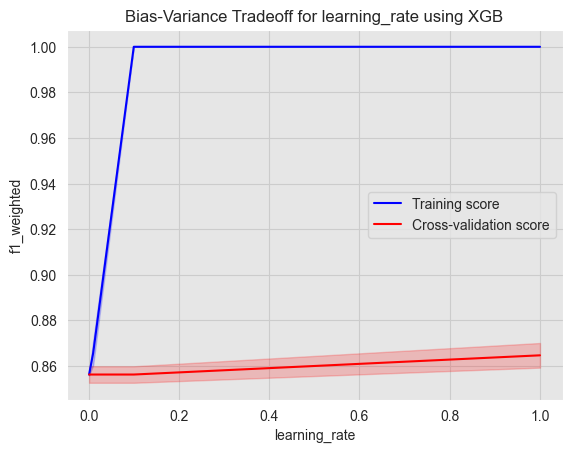

Value [3, 5, 7, 9]


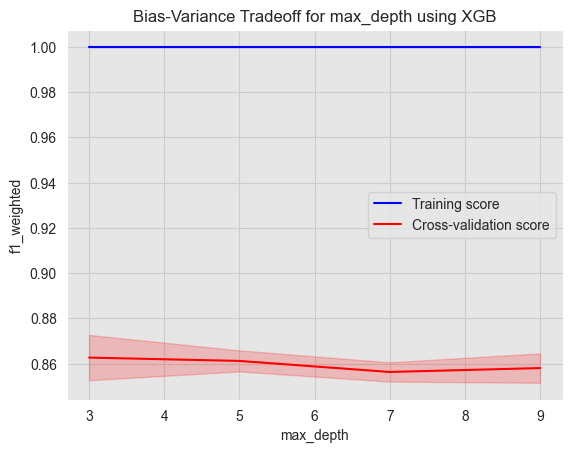

Value [50, 100, 200]


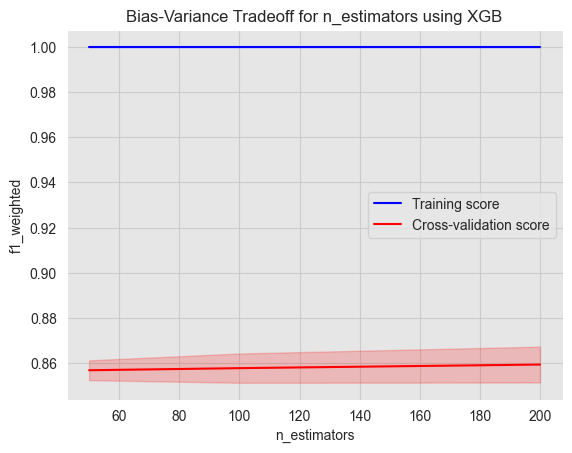

Value [0, 0.1, 0.2, 0.3]


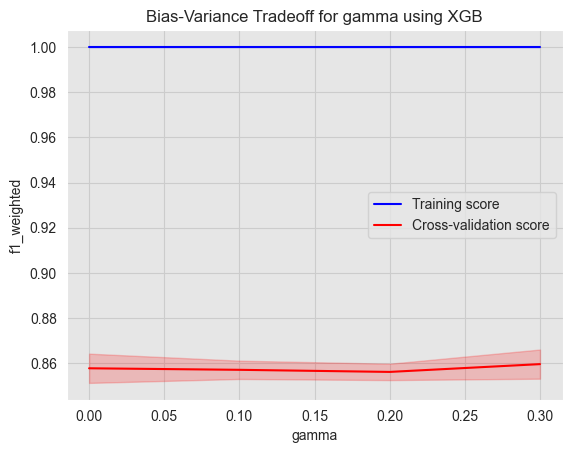

In [29]:
plot_hyper_param_train_validation_curve(estimator=xgb.XGBClassifier(**params), param_grid=param_grid, X=X, y=y, cv=NUM_FOLDS, scoring='f1_weighted', modelname='XGB')


accuracy:  0.8960000000000001
f1_macro:  0.5594961887927564
f1_micro:  0.8960000000000001
Accuracy Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) is: 0.6635050505050505


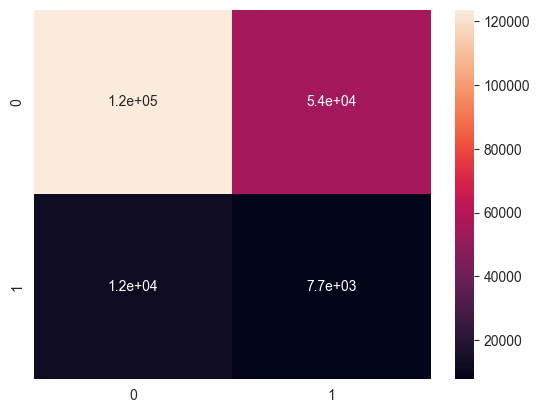

Classification Report of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) is: 
              precision    recall  f1-score   support

           0       0.91      0.69      0.79    178097
           1       0.12      0.39      0.19     19903

    accuracy                           0.66    198000
  

<Figure size 640x480 with 0 Axes>

In [30]:
# Add best params
best_params = {
    'device': 'cuda',
    'tree_method': 'hist',
    'learning_rate': 1,
    'max_depth': 3,
    'n_estimators': 200,
    'gamma': 0
}
xgb_model = xgb.XGBClassifier(**best_params)


# best paramters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
# train the xgb_model
xgb_model.fit(X, y)
# validate the xgb_model
cv_results = cross_validate(xgb_model, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

# predict the validation set
y_pred = xgb_model.predict(X_test)

# Accuracy Score
print("Accuracy Score of " + str(xgb_model) + " is: " + str(accuracy_score(y_test, y_pred)))

# Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()
# save the plot
plt.savefig(f'../images/{model_name}/evaluation_confusion_matrix.png', dpi=300, bbox_inches='tight')
# Classification Report
print("Classification Report of " + str(xgb_model) + " is: \n" + str(classification_report(y_test, y_pred)))

# Weighted F1 Score
print("F1 Score of " + str(xgb_model) + " is: " + str(f1_score(y_test, y_pred, average='weighted')))

## Bias-Variance Analysis


In [32]:
mse, bias, var = get_bias_variance(
    xgb_model, X_train=X, y_train=y, X_test=X_test, y_test=y_test)


In [33]:
print("mse: ", mse)
print("bias: ", bias)
print("var: ", var)


mse:  0.3920852525252525
bias:  0.1669086679292929
var:  0.22517658459595954
